In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import os
import numpy as np
import pandas as pd
import cv2
import shutil
import pickle
from tqdm.auto import tqdm
from pathlib import Path
from multiprocessing.pool import ThreadPool
from scipy.spatial import distance
from strikes import load_strikes, Loader, StrikeAnalyzer, MissingStrikeData, StrikeException, PoseEstimator
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
os.chdir('/data/Pogona_Pursuit/Arena')
pe = PoseEstimator('front')
pe.init(cv2.imread('/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671355977.6631668.jpg'))

2023-01-26 10:03:48 - calibration-pose-estimator - INFO - MainProcess - started pose-estimator caliber for frames of shape: (1088, 1456)


In [31]:
ARUCO_MARKER_SIZE = 3.5
d = pe.markers[0]
pixel2cm = ARUCO_MARKER_SIZE / distance.euclidean(d['top_right'], d['bottom_right'])
pixel2cm

0.03823139315409891

In [27]:
output_folder = '/data/Pogona_Pursuit/output/strike_analysis'

In [28]:
with open(f'{output_folder}/pose_dfs.pkl', 'rb') as f:
    pose_dfs = pickle.load(f)
df = pd.read_parquet(f'{output_folder}/strikes_df.parquet')

In [2]:
strikes_ids = sorted(load_strikes('PV80'))

  0%|          | 0/465 [00:00<?, ?it/s]

SID-7018: 'DataFrame' object has no attribute 'time'


<AxesSubplot:xlabel='speed', ylabel='max_accl'>

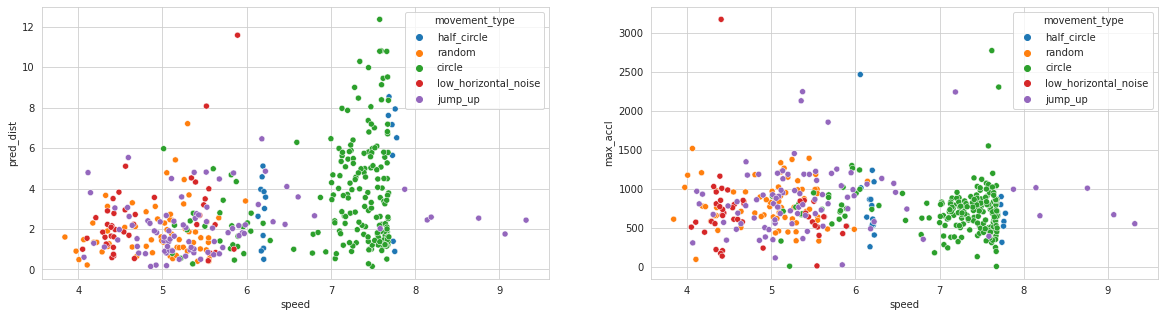

In [3]:
%matplotlib inline
df = []
pose_dfs = {}
for sid in tqdm(strikes_ids):
    try:
        ld = Loader(sid, 'front', is_debug=False, is_load_tongue=False)
        sa = StrikeAnalyzer(ld)
        df.append({'speed': sa.bug_speed, 'max_accl': sa.max_acceleration, 'pred_dist': sa.prediction_distance,
                   'movement_type': ld.get_block_info().get('movement_type'), 'time': ld.info.get('time'),
                   'leap_frame': sa.leap_frame, 'strike_id': sid})
        pose_dfs[sid] = sa.pose_df.loc[sa.relevant_frames].copy()
    except (MissingStrikeData, StrikeException):
        continue
    except Exception as exc:
        print(f'SID-{sid}: {exc}')
df = pd.DataFrame(df)

with open(f'{output_folder}/pose_dfs.pkl', 'wb') as f:
    pickle.dump(pose_dfs, f)
df.to_parquet(f'{output_folder}/strikes_df.parquet')

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.scatterplot(data=df, x='speed', y='pred_dist', hue='movement_type', ax=axes[0])
sns.scatterplot(data=df, x='speed', y='max_accl', hue='movement_type', ax=axes[1])
plt.show()

In [12]:
pose_dfs[7024]

,time,cam_x,cam_y,prob,x,y,is_in_screen,orig_x,orig_y,velocity,velocity_y,acceleration,acceleration_y,rel_time
1964,2022-12-22 13:45:11.187553536,962.654114,851.558777,0.999996,NaN,NaN,-1.0,962.654114,851.558777,55.371592,-53.947360,225.965479,202.754822,-2.999651
1965,2022-12-22 13:45:11.204218368,962.711914,851.508545,0.999996,NaN,NaN,-1.0,962.711914,851.508545,51.712158,-50.568506,225.965479,202.754822,-2.982986
1966,2022-12-22 13:45:11.220883200,962.717712,851.482727,0.999996,NaN,NaN,-1.0,962.717712,851.482727,48.069134,-47.189652,225.965479,202.754822,-2.966321
1967,2022-12-22 13:45:11.237547776,962.654114,851.487854,0.999996,NaN,NaN,-1.0,962.654114,851.487854,44.446556,-43.810798,225.965479,202.754822,-2.949657
1968,2022-12-22 13:45:11.254212608,962.817200,851.261292,0.999996,NaN,NaN,-1.0,962.817200,851.261292,40.849862,-40.431944,225.965479,202.754822,-2.932992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,2022-12-22 13:45:16.120312832,1027.759888,912.063049,0.999992,NaN,NaN,-1.0,1027.759888,912.063049,NaN,NaN,NaN,NaN,1.933108
2261,2022-12-22 13:45:16.136977664,1028.069214,911.804443,0.999991,NaN,NaN,-1.0,1028.069214,911.804443,NaN,NaN,NaN,NaN,1.949773
2262,2022-12-22 13:45:16.153642496,1028.268433,911.793030,0.999991,NaN,NaN,-1.0,1028.268433,911.793030,NaN,NaN,NaN,NaN,1.966438
2263,2022-12-22 13:45:16.170307072,1028.828125,911.531982,0.999989,NaN,NaN,-1.0,1028.828125,911.531982,NaN,NaN,NaN,NaN,1.983103


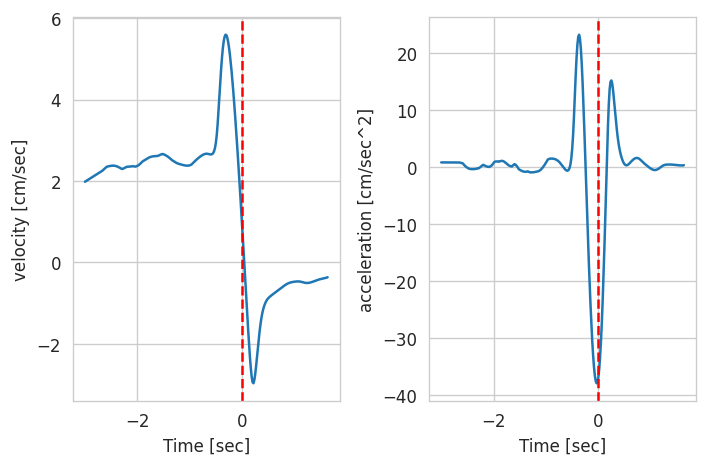

In [69]:
%matplotlib inline
length = 300
res = {'velocity': [], 'acceleration': []}
fig, axes = plt.subplots(1, len(res), dpi=120)
for i, (label, label_list) in enumerate(res.items()):
    for sid, xf in pose_dfs.items():
        if len(xf) < length:
            continue
        strike_frame = xf.query('rel_time==0').index[0]
        seg = xf.iloc[:length][f'{label}_y'].values
        t = xf.iloc[:length]['rel_time']
        label_list.append(seg)

    res[label] = np.vstack(label_list)

    axes[i].plot(t, res[label].mean(axis=0) * pixel2cm)
    axes[i].axvline(0, color='red', linestyle='--')
    # axes[i].set_title(label)
    axes[i].set_xlabel('Time [sec]')
    axes[i].set_ylabel(label + ' ' + ('[cm/sec]' if label == 'velocity' else '[cm/sec^2]'))

fig.tight_layout()

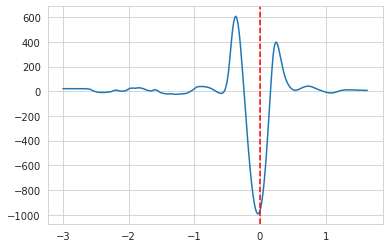

In [11]:
xf = sa.pose_df.loc[sa.relevant_frames].copy()
# sns.lineplot(data=xf, x='time', y='cam_y')
xf

,time,cam_x,cam_y,prob,x,y,is_in_screen,orig_x,orig_y,velocity,velocity_y,acceleration,acceleration_y,rel_time
1977,2022-11-26 11:26:09.661014784,438.833771,834.245728,0.999986,NaN,NaN,-1.0,438.833771,834.245728,0.333539,-0.064148,0.931127,-0.371365,-2.999651
1978,2022-11-26 11:26:09.677679616,438.845032,834.272095,0.999986,NaN,NaN,-1.0,438.845032,834.272095,0.320886,-0.070337,0.931127,-0.371365,-2.982986
1979,2022-11-26 11:26:09.694344192,438.839111,834.261230,0.999987,NaN,NaN,-1.0,438.839111,834.261230,0.308495,-0.076525,0.931127,-0.371365,-2.966321
1980,2022-11-26 11:26:09.711009024,438.861511,834.276123,0.999986,NaN,NaN,-1.0,438.861511,834.276123,0.296399,-0.082714,0.931127,-0.371365,-2.949657
1981,2022-11-26 11:26:09.727673856,438.857361,834.273682,0.999986,NaN,NaN,-1.0,438.857361,834.273682,0.284634,-0.088903,0.931127,-0.371365,-2.932992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2022-11-26 11:26:14.593774080,536.953125,917.671265,0.999975,NaN,NaN,-1.0,536.953125,917.671265,NaN,NaN,NaN,NaN,1.933108
2274,2022-11-26 11:26:14.610438912,536.923767,917.748596,0.999975,NaN,NaN,-1.0,536.923767,917.748596,NaN,NaN,NaN,NaN,1.949773
2275,2022-11-26 11:26:14.627103488,536.917725,917.689331,0.999976,NaN,NaN,-1.0,536.917725,917.689331,NaN,NaN,NaN,NaN,1.966438
2276,2022-11-26 11:26:14.643768320,536.895325,917.680847,0.999976,NaN,NaN,-1.0,536.895325,917.680847,NaN,NaN,NaN,NaN,1.983103


In [12]:
sa.leap_frame

2094

In [10]:
cma = CircleMultiTrialAnalysis(is_use_cache=False)
cma.df
# cma.plot_circle_strikes()

,strike_id,time,bug_pos_x,bug_pos_y,strike_pos_x,strike_pos_y
0,6550,2022-12-06 10:18:32.880,1181.345834,604.391463,1244.0,446.0
1,6552,2022-12-06 10:20:28.695,889.851791,694.031696,1019.0,710.0
2,6553,2022-12-06 10:20:33.900,673.938191,503.743228,797.0,637.0
3,6547,2022-12-06 10:18:20.608,1104.944091,664.217309,763.0,624.0
4,6546,2022-12-06 10:18:19.150,1104.944091,664.217309,1222.0,525.0
...,...,...,...,...,...,...
99,6766,2022-12-08 13:59:50.236,923.355249,699.857606,1006.0,705.0
100,6768,2022-12-08 13:59:59.253,1050.419065,687.640875,1190.0,627.0
101,6770,2022-12-08 14:00:09.266,975.427443,701.427420,1101.0,701.0
102,6772,2022-12-08 14:00:14.491,1372.593720,677.984107,1390.0,710.0


In [29]:
%matplotlib notebook
cma.plot_circle_strikes()

<IPython.core.display.Javascript object>

In [4]:
for sid in load_strikes('PV80'):
    ld = Loader(sid, 'front')
    sa = StrikeAnalyzer(ld)
    break

In [ ]:
%%time
ld = Loader(5895, 'front')
sa = StrikeAnalyzer(ld)
sa.plot_strike_analysis()

NameError: name 'tqdm' is not defined

Text(0.5, 0, 'Strike Index')

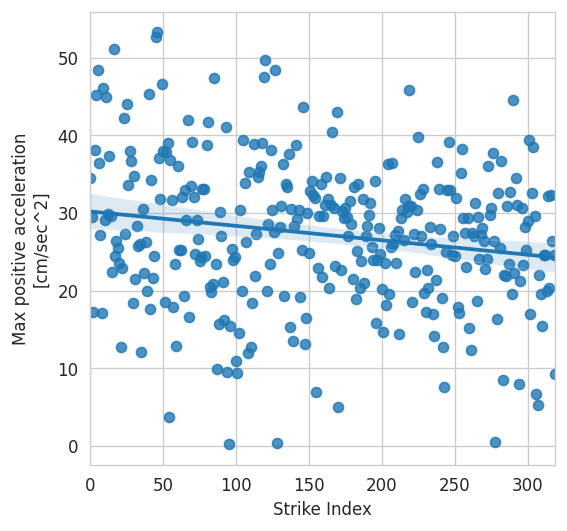

In [36]:
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(5, 5))
max_accl_value = 1500
df_ = df.query(f'movement_type!="jump_up" and max_accl < {max_accl_value}').sort_values(by='time').copy()
# df_['x_vals'] = np.linspace(0, max_accl_value, len(df_))
df_['x_vals'] = np.arange(0, len(df_))
df_['max_accl'] = df_.max_accl.values * pixel2cm
sns.regplot(data=df_, x='x_vals', y='max_accl', ax=ax)#, hue='movement_type')
# ax.axis('square')
ax.set_ylabel('Max positive acceleration\n[cm/sec^2]')
ax.set_xlabel('Strike Index')
# ax.set_ylim([0, 1500])
# ax.set_xlim([0, 1500])
# ax.set_aspect('equal', 'box')

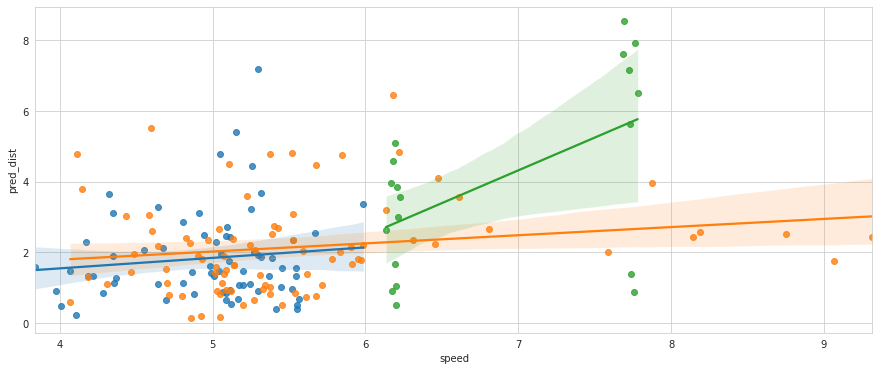

In [5]:
plt.figure(figsize=(15, 6))
for mt in ['random', 'jump_up', 'half_circle']:
    sns.regplot(data=df.query(f'movement_type=="{mt}"'), x='speed', y='pred_dist')
# sns.scatterplot(data=df, x='speed', y='max_accl', hue='movement_type', ax=axes[1])

In [44]:
df

,speed,max_accl,pred_dist,movement_type,time
0,7.731435,902.127792,5.639215,half_circle,2022-11-26 11:26:12.653
1,4.983022,773.130191,1.605606,random,2022-11-27 13:32:17.291
2,5.295114,450.831225,1.934813,random,2022-11-27 13:33:04.841
3,5.545338,996.868055,1.337004,random,2022-11-27 14:41:01.771
4,4.807038,1182.956132,1.144293,random,2022-11-27 15:33:25.809
...,...,...,...,...,...
86,4.486950,782.213759,1.968045,jump_up,2022-12-18 15:22:48.882
87,4.700725,1348.173966,1.137173,jump_up,2022-12-19 14:53:28.983
88,5.522947,683.894673,2.359213,jump_up,2022-12-19 14:53:57.117
89,5.716049,1199.971469,1.081463,jump_up,2022-12-19 14:53:58.312


In [7]:
sa.pose_df.query('is_in_screen==1')

,time,cam_x,cam_y,prob,x,y,is_in_screen,"(tongue, )",dist,velocity,acceleration,rel_time
7171,2022-11-27 13:32:17.184013568,827.745361,940.677429,0.973324,22.343274,4.021227,1.0,0,22.702250,3.216032,8.199314,-0.099988
7172,2022-11-27 13:32:17.200678400,822.118652,953.689880,0.995468,22.966786,3.751591,1.0,1,23.271178,2.968033,7.110710,-0.083324
7173,2022-11-27 13:32:17.217342976,822.313599,954.486328,0.998474,22.353779,3.710970,1.0,1,22.659716,4.118054,7.969596,-0.066659
7174,2022-11-27 13:32:17.234007808,824.504822,951.475525,0.991876,23.485549,4.044464,1.0,1,23.831255,4.377535,7.861058,-0.049994
7175,2022-11-27 13:32:17.250672640,843.185303,947.936096,0.994977,22.966640,3.942022,1.0,1,23.302492,5.380818,6.147988,-0.033329
7176,2022-11-27 13:32:17.267336960,850.812805,941.301880,0.992288,24.148868,4.270336,1.0,0,24.523532,4.845583,6.311045,-0.016665


In [23]:
min_dist = 40
dest_dir = '/data/Pogona_Pursuit/output/models/deeplabcut/train/front_head_only/labeled-data/january23'

img_dirs = list(Path('/data/Pogona_Pursuit/output/strike_analysis/PV80').glob('*'))
for input_dir in tqdm(img_dirs):
    if not input_dir.is_dir():
        continue

    images = []
    img_files = list(input_dir.glob('*.jpg'))
    for p in img_files.copy():
        img = cv2.imread(p.as_posix(), 0)
        if img.shape != (1088, 1456):
            img_files.remove(p)
            continue
        img = cv2.resize(img, None, None, fx=0.5, fy=0.5)
        images.append(img)

    n = len(images)
    def iter1(*l):
        M_ = np.zeros((n, n))
        for i in l:
            for j in range(i + 1, n):
                M_[i, j] = np.mean(np.abs(images[i] - images[j]))
        return M_

    with ThreadPool() as pool:
        M = pool.starmap(iter1, np.array_split(np.arange(n).astype(int), 10))
    M = np.sum(M, axis=0)

    r, c = np.where((0 < M) & (M < min_dist))

    def get_neighs(i):
        idx = np.where(r == i)[0]
        return c[idx]

    processed_ids = set()
    for i, k in enumerate(np.unique(r)):
        if k in processed_ids:
            continue
        neighs = get_neighs(k)
        g = [k] + neighs.tolist()
        processed_ids.update(g)
        shutil.copyfile(img_files[k], f'{dest_dir}/{img_files[k].name}')

  0%|          | 0/894 [00:00<?, ?it/s]

In [24]:
df = pd.read_csv('/data/Pogona_Pursuit/output/models/deeplabcut/train/front_head_only/labeled-data/january23/january23DLC_resnet50_front_head_onlyJan23shuffle0_500000.csv')
df

,scorer,DLC_resnet50_front_head_onlyJan23shuffle0_500000,DLC_resnet50_front_head_onlyJan23shuffle0_500000.1,DLC_resnet50_front_head_onlyJan23shuffle0_500000.2,DLC_resnet50_front_head_onlyJan23shuffle0_500000.3,DLC_resnet50_front_head_onlyJan23shuffle0_500000.4,DLC_resnet50_front_head_onlyJan23shuffle0_500000.5,DLC_resnet50_front_head_onlyJan23shuffle0_500000.6,DLC_resnet50_front_head_onlyJan23shuffle0_500000.7,DLC_resnet50_front_head_onlyJan23shuffle0_500000.8,...,DLC_resnet50_front_head_onlyJan23shuffle0_500000.23,DLC_resnet50_front_head_onlyJan23shuffle0_500000.24,DLC_resnet50_front_head_onlyJan23shuffle0_500000.25,DLC_resnet50_front_head_onlyJan23shuffle0_500000.26,DLC_resnet50_front_head_onlyJan23shuffle0_500000.27,DLC_resnet50_front_head_onlyJan23shuffle0_500000.28,DLC_resnet50_front_head_onlyJan23shuffle0_500000.29,DLC_resnet50_front_head_onlyJan23shuffle0_500000.30,DLC_resnet50_front_head_onlyJan23shuffle0_500000.31,DLC_resnet50_front_head_onlyJan23shuffle0_500000.32
0,bodyparts,nose,nose,nose,left_ear,left_ear,left_ear,right_ear,right_ear,right_ear,...,forelegR1,forelegR2,forelegR2,forelegR2,hindlegR1,hindlegR1,hindlegR1,hindlegR2,hindlegR2,hindlegR2
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,...,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,10003.jpg,938.6676173210144,910.7375531196594,0.9767455458641052,959.6655464172363,810.3972120285034,0.9740538001060486,897.1644303798676,828.323385477066,0.4437323808670044,...,0.6686668992042542,875.239548265934,805.4985208511353,0.9914679527282715,771.4655175209045,722.5503233671188,0.99342280626297,828.5808423757553,688.7177753448486,0.8747593760490417
3,10017.jpg,787.5570618212223,856.863986492157,0.9921640157699585,774.7142310142517,772.6826422810555,0.9958284497261047,713.0575308799744,804.2354907542467,0.9905331134796143,...,0.9648893475532532,680.3309206962585,775.451500415802,0.9588372111320496,639.4004583358765,644.3812803328037,0.9905937910079956,696.1520867347717,637.2046607732773,0.9693682193756104
4,10021.jpg,694.3849503993988,963.125092625618,0.999414324760437,729.9249193668365,879.9256825447083,0.9886947274208069,650.1875425577164,876.7247042655945,0.9963743090629578,...,0.9678944945335388,637.4037101268768,846.3213798999786,0.9854853749275208,594.2254005670547,597.6173478364944,0.8506231307983398,682.9341278076172,673.0247061252594,0.32816824316978455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,9926.jpg,716.105920560658,771.390604019165,0.9213348031044006,928.0430221557617,842.168905377388,0.9508827924728394,856.4987812042236,831.5222585201263,0.9707717895507812,...,0.5897871851921082,830.65252161026,852.6176269650459,0.9195052981376648,665.677383184433,745.5168447494507,0.7419232130050659,740.8812079429626,734.8614587783813,0.9964950680732727
866,9963.jpg,528.349452495575,950.9848549365997,0.9983591437339783,551.2985818386078,870.5691492557526,0.9950942993164062,464.5083737373352,881.5460135936737,0.9938499927520752,...,0.17235548794269562,475.11984115839005,834.0080424547195,0.7667224407196045,458.9980971813202,709.3979576826096,0.9292312264442444,513.4983439445496,721.200777053833,0.9979900121688843
867,9971.jpg,554.4425444602966,955.5840502977371,0.9966675639152527,615.0518107414246,872.7615613937378,0.9776174426078796,528.192232131958,853.3529989719391,0.9823969602584839,...,0.4168342351913452,541.0483312606812,840.7928647994995,0.9286630749702454,492.7982787489891,703.783787727356,0.9889158010482788,537.5652320384979,712.1890716552734,0.9856172204017639
868,9974.jpg,709.0953752994537,913.7478375434875,0.9977625608444214,758.0432567596436,845.5246654748917,0.8912354111671448,682.1661496162415,824.0283858776093,0.9534719586372375,...,0.8745236396789551,679.0346565246582,800.9428994655609,0.961076557636261,672.5930123329163,639.3597269058228,0.9736594557762146,727.2242438793182,668.5225431919098,0.9909883141517639


In [35]:
df['scorer'] = df.scorer.map(lambda x: 'labeled-data/january23/' + x if x.endswith('.jpg') else x)

In [37]:
df.to_csv('/data/Pogona_Pursuit/output/models/deeplabcut/train/front_head_only/labeled-data/january23/new.csv', index=False)

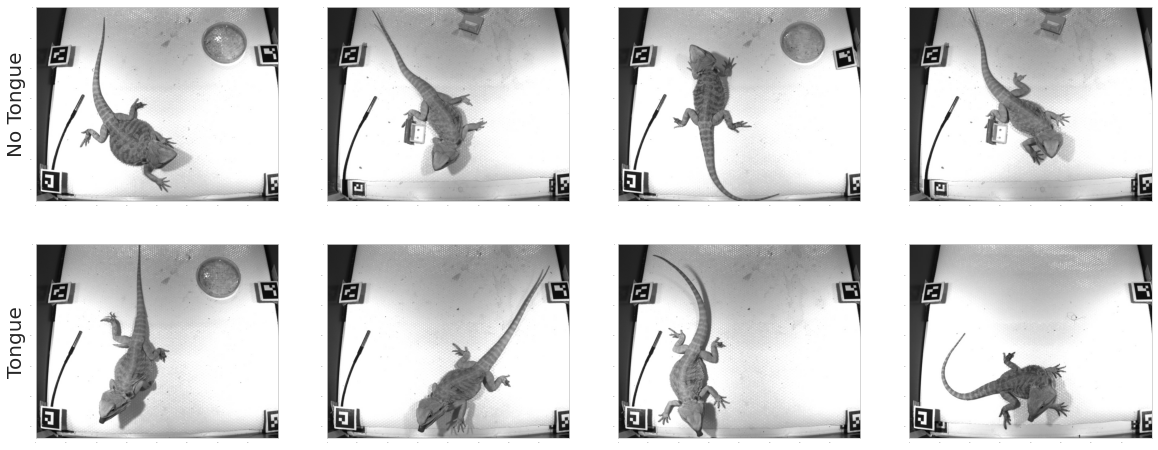

In [25]:
%matplotlib inline
no_tongues = [
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671274293.5356143.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671708287.8965828.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671362490.5120733.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/no_tongues/1671708285.7135038.jpg'
]
tongues = [
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671454845.3467727.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671628346.4125195.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/1671628350.478713.jpg',
    '/data/Pogona_Pursuit/output/datasets/pogona_tongue/dataset/tongues/front_20221127T163004_3508.jpg'
]

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, p in enumerate(no_tongues):
    axes[0, i].imshow(cv2.imread(p)[300:940, 300:1100])
    if i == 0:
        axes[0, i].set_ylabel('No Tongue', fontsize=20)
    axes[0, i].tick_params(axis=u'both', which=u'both',length=0, labelsize=0)
    axes[0, i].grid(False)
for i, p in enumerate(tongues):
    axes[1, i].imshow(cv2.imread(p)[300:940, 300:1100])
    if i == 0:
        axes[1, i].set_ylabel('Tongue', fontsize=20)
    axes[1, i].tick_params(axis=u'both', which=u'both',length=0, labelsize=0)
    axes[1, i].grid(False)